# Model Sistem Rekomendasi Produk Skincare : Content-Based Filtering


## Business Understanding
### Problem Statements
* Bagaimana cara merekomendasikan produk yang relevan kepada pengguna berdasarkan produk yang mereka cari?

### Goals
* Membangun sistem rekomendasi untuk produk Sephora dan menyediakan rekomendasi top-N produk serupa berdasarkan produk dan kategori produk.

### Solution Statements
* Sistem akan mengekstrak fitur penting dari setiap produk, seperti bahan (ingredients), deskripsi produk, kategori, dan jenis produk.
* Dengan menggunakan teknik TF-IDF vectorization dan cosine similarity, sistem akan menghitung kemiripan antar produk berdasarkan kontennya.
* Sistem ini tidak memerlukan data dari pengguna lain (seperti pada collaborative filtering), sehingga bisa langsung memberikan rekomendasi bahkan untuk pengguna baru.

## Data Understanding
Dataset Sephora Products and Skincare Reviews yang berasal dari [Kaggle](https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews?select=product_info.csv). Dataset ini memiliki 8494 baris dan 27 kolom yang terdiri atas 15 kolom numerik dan 12 kolom kategorikal. Penjelasan lebih rinci akan dijelaskan dalam tahap berikut ini:




## Data Understanding

Dalam tahap ini, data akan diproses untuk memahami isi dari dataset.

### Data Loading

#### Import Library

Mengimport seluruh library yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import kagglehub
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Fungsi semua library yang diimport:
1. **import pandas as pd** : untuk manipulasi dan analisis data
2. **import numpy as np** : untuk operasi numerik dan array multidimensi
3. **import matplotlib.pyplot as plt** : untuk visualisasi data
4. **import seaborn as sns** : untuk visualisasi statistik
5. **from sklearn.impute import SimpleImputer** : untuk mengimputasi nilai yang hilang
6. **import kagglehub** : untuk mengakses dataset dari KaggleHub
7. **import nltk** : library NLP untuk mengolah teks
8. **nltk.download('stopwords')** : mendowload resource stopwords
9. **from nltk.corpus import stopwords** : untuk mengenali kata-kata umum yang tidak terlalu bermakna
10. **import re** :  untuk membersihkan teks
11. **from sklearn.feature_extraction.text import TfidfVectorizer** : untuk mengubah teks menjadi angka berbasis bobot TF-IDF untuk mengukur pentingnya kata
12. **from sklearn.metrics.pairwise import cosine_similarity** : untuk mengukur seberapa mirip dua teks berdasarkan sudut vektor dalam ruang multidimensi
13. **from tabulate import tabulate** : untuk membuat tabel dalam format teks yang rapi dan mudah dibaca dari data seperti list, dictionary, atau DataFrame.

#### Memuat Dataset

Pada tahap ini memuat dataset ke dalam notebook. Karena dataset memiliki format CSV, maka menggunakan library pandas untuk membacanya.

In [2]:
path = kagglehub.dataset_download("nadyinky/sephora-products-and-skincare-reviews")
file_path = path + "/product_info.csv"
data = pd.read_csv(file_path)

100%|██████████| 147M/147M [00:01<00:00, 144MB/s]

Extracting files...


### Exploratory Data Analysis (EDA)

Analisis karakteristik, menemukan pola, anomali, dan memeriksa asumsi pada data.

#### Cek Tipe Data

Dilakukan untuk menampilkan jumlah baris, kolom, tipe data, dan jumlah nilai non-null.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

Terlihat bahwa dataset memiliki 8494 baris dan 27 kolom yang terdiri dari 12 kolom data kategorikal dan 15 kolom data numerik. Berikut adalah seluruh fitur yang ada dalam dataset:
1. Product_id : kode unik produk dari situs
2. Product_name : nama lengkap dari produk
3. Brand_id : kode unik untuk merek produk dari situr
4. Brand_name : nama lengkap dari merek produk
5. Loves_count : jumlah orang yang menandai produk sebagai favorit
6. Rating : rata-rata ulasan produk berdasarkan ulasan pengguna
7. Reviews : jumlah ulasan pengguna untuk sebuah produk
8. Size : ukuran dari produk, dapat dalam bentuk oz, ml, g, packs, atau satuan lain sesuai dengan tipe produk
9. Variation_type : tipe dari parameter variasi untuk produk (contoh: ukuran, warna)
10. Variation_value : nilai spesifik dari parameter variasi produk (contoh: 100 mL, Golden Sand)
11. Variation_desc : deskripsi dari parameter variasi produk (contoh: tone untuk kulit pucat)
12. Ingredients : list komposisi yang terkandung dalam produk, contoh [‘Product variation 1:’, ‘Water, Glycerin’, ‘Product variation 2:’, ‘Talc, Mica’] or if no variations [‘Water, Glycerin’]
13. Price_usd : harga produk dalam dollar US
14. value_price_usd : potensi penghematan biaya produk, ditampilkan disebelah harga asli
15. Sale_price_usd : harga promo produk dalam dollar US
16. Limited_edition : indikasi produk adalah edisi terbatas atau tidak (1-iya, 0-tidak)
17. New : indikasi produk barang baru atau bukan (1-iya, 0-tidak)
18. Online_only : indikasi produk hanya dijual secara online atau tidak (1-iya, 0-tidak)
19. Out_of_stock : indikasi produk sedang kehabisan stok atau tidak (1-iya, 0-tidak)
20. Sephora_exclusive : indikasi produk adalah barang ekslusif Sephora atau bukan (1-iya, 0-tidak)
21. Highlights : list berisi tag atau fitur yang menonjolkan atribut produk (contoh: vegan, matte finish)
22. Primary_category : kategori pertama dibagian breadcrumb
23. Secondly_category : kategori kedua dibagian breadcrumb
24. Tertiary_category : kategori ketiga dibagian breadcrumb
25. Child_count : jumlah variasi dari ketersediaan produk
26. Child_mac_price : harga tertinggi dari variasi produk
27. Child_min_price : harga terendah dari variasi produk


Dengan tipe data sebagai berikut:
* Terdapat 12 tipe data object
* Terdapat 8 tipe data int64
* Terdapat 7 tipe data float64

#### Cek Isi Baris

In [4]:
data.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


#### Cek Deskripsi Statistik

Dilakukan untuk mengetahui distribusi awal data, mengidentifikasi outlier, dan melihat apakah data memiliki variansi atau semuanya sama.

In [5]:
data.describe(include='all')

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
count,8494,8494,8494.000000,8494,8.494000e+03,8216.000000,8216.000000,6863,7050,6896,...,8494.000000,8494.000000,8494.000000,6287,8494,8486,7504,8494.000000,2754.000000,2754.000000
unique,8494,8415,NaN,304,NaN,NaN,NaN,2055,7,2729,...,NaN,NaN,NaN,4417,9,41,118,NaN,NaN,NaN
top,P505461,Discovery Set,NaN,SEPHORA COLLECTION,NaN,NaN,NaN,1.7 oz/ 50 mL,Size,1.7 oz/ 50 mL,...,NaN,NaN,NaN,"['Layerable Scent', 'Floral Scent']",Skincare,Women,Perfume,NaN,NaN,NaN
freq,1,3,NaN,352,NaN,NaN,NaN,500,4043,374,...,NaN,NaN,NaN,64,2420,875,568,NaN,NaN,NaN
mean,NaN,NaN,5422.440546,NaN,2.917957e+04,4.194513,448.545521,NaN,NaN,NaN,...,0.219096,0.073699,0.279374,NaN,NaN,NaN,NaN,1.631622,53.792023,39.665802
std,NaN,NaN,1709.595957,NaN,6.609212e+04,0.516694,1101.982529,NaN,NaN,NaN,...,0.413658,0.261296,0.448718,NaN,NaN,NaN,NaN,5.379470,58.765894,38.685720
min,NaN,NaN,1063.000000,NaN,0.000000e+00,1.000000,1.000000,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,3.000000,3.000000
25%,NaN,NaN,5333.000000,NaN,3.758000e+03,3.981725,26.000000,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,22.000000,19.000000
50%,NaN,NaN,6157.500000,NaN,9.880000e+03,4.289350,122.000000,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,32.000000,28.000000
75%,NaN,NaN,6328.000000,NaN,2.684125e+04,4.530525,418.000000,NaN,NaN,NaN,...,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,59.000000,42.000000


Fungsi describe digunakan untuk memberikan informasi statistik.

* Count adalah jumlah sampel pada data.
* Mean adalah nilai rata-rata.
* Std adalah standar deviasi.
* Min yaitu nilai minimum.
* 25% adalah kuartil pertama.
* 50% adalah kuartil kedua.
* 75% adalah kuartil ketiga.
* Max adalah nilai maksimum.

#### Cek Data Hilang dan Penanganannya

Melakukan cek missing value di data understanding berguna agar data yang bersih, saat data memasuki tahap EDA sudah tidak ada anomali yang dapat mengganggu hasil dari EDA nya.


In [6]:
missing_values = data.isna().sum()
print(missing_values)

product_id               0
product_name             0
brand_id                 0
brand_name               0
loves_count              0
rating                 278
reviews                278
size                  1631
variation_type        1444
variation_value       1598
variation_desc        7244
ingredients            945
price_usd                0
value_price_usd       8043
sale_price_usd        8224
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            2207
primary_category         0
secondary_category       8
tertiary_category      990
child_count              0
child_max_price       5740
child_min_price       5740
dtype: int64


Terlihat bahwa dalam dataset terdapat missing value.
Berikut penanganan yang sesuai dengan tipe data masing-masing fitur:
- Untuk fitur rating dan reviews menggunakan imputasi dengan median. Kkarena fitur ini termasuk fitur numerikal, maka imputasi yang dilakukan menggunakan median.
- Untuk fitur size, variation_type, variation_value, ingredients, highlights, secondary_category, tertiary_category imputasi dengan string "Unknown". Karena fitur tersebut termasuk fitur kategorikal, maka imputasi yang dilakukan menggunakan string.
- Untuk variation_desc, value_price_usd, sale_price_usd, child_min_price, child_max_price akan dihapus karena terlalu banyak missing value.

Walaupun penanganan missing value termasuk tahap data preparation, namun tetap dilakukan sebelum EDA agar hasil dari EDA dapat memberikan hasil yang maksimal.

In [7]:
# Menghapus fitur yang memiliki banyak missing value >85% kosong.
data = data.drop(['variation_desc', 'value_price_usd', 'sale_price_usd', 'child_max_price', 'child_min_price'], axis=1)

In [8]:
# Imputasi semua missing values numerik kontinu dengan median
data.fillna(data.median(numeric_only=True), inplace=True)
print(data.isnull().sum())

product_id               0
product_name             0
brand_id                 0
brand_name               0
loves_count              0
rating                   0
reviews                  0
size                  1631
variation_type        1444
variation_value       1598
ingredients            945
price_usd                0
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            2207
primary_category         0
secondary_category       8
tertiary_category      990
child_count              0
dtype: int64


In [9]:
# Imputasi semua missing values kategorik dengan string Unknown
data.fillna({
    'ingredients': 'Unknown',
    'variation_type': 'Unknown',
    'variation_value': 'Unknown',
    'size': 'Unknown',
    'highlights': 'Unknown',
    'secondary_category': 'Unknown',
    'tertiary_category': 'Unknown'
}, inplace=True)
print(data.isnull().sum())

product_id            0
product_name          0
brand_id              0
brand_name            0
loves_count           0
rating                0
reviews               0
size                  0
variation_type        0
variation_value       0
ingredients           0
price_usd             0
limited_edition       0
new                   0
online_only           0
out_of_stock          0
sephora_exclusive     0
highlights            0
primary_category      0
secondary_category    0
tertiary_category     0
child_count           0
dtype: int64


Setelah imputasi dilakukan, sudah tidak ada lagi data yang hilang.

#### Cek Duplikasi Data

Dilakukan untuk menghindari bias dari data yang muncul dua kali.

In [10]:
duplicates = data.duplicated()
print("Baris duplikat:", duplicates.sum())

Baris duplikat: 0


Tidak terdapat data yang terduplikasi

### EDA - Univariate Analysis

Dilakukan untuk memahami persebaran nilai, baik dari fitur numerik maupun fitur kategorikal.

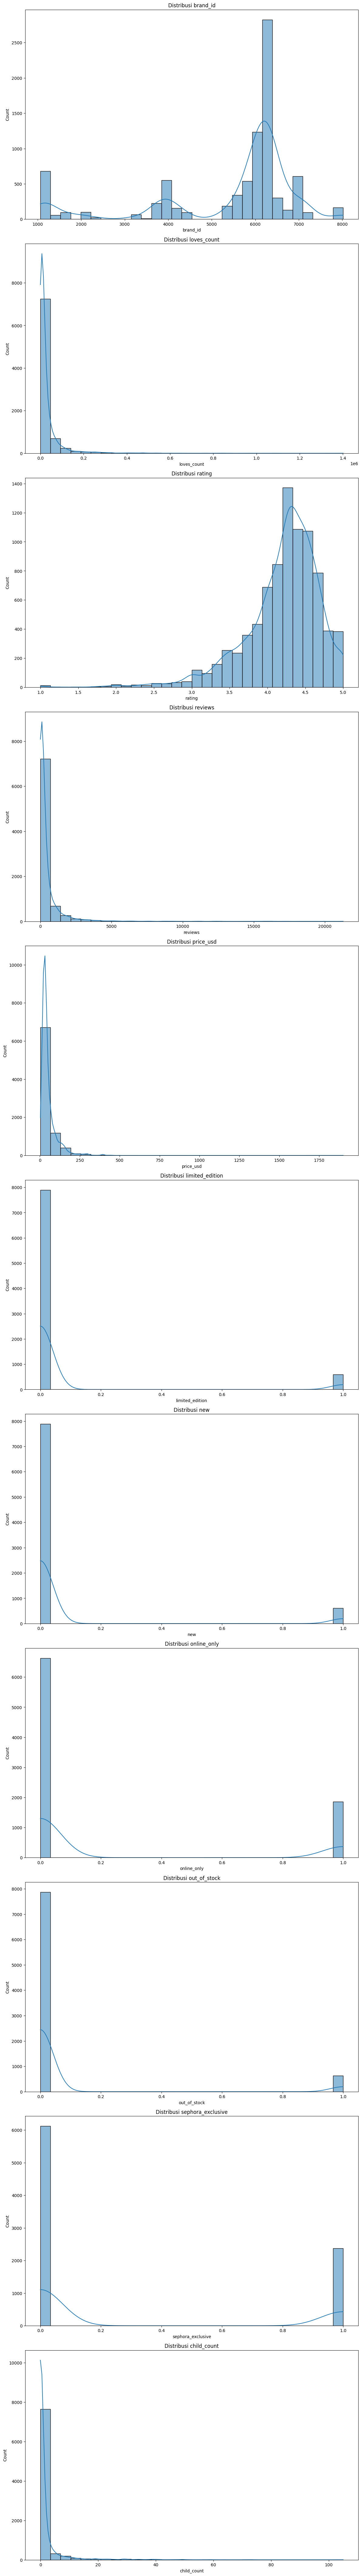

In [11]:
numeric_features = data.select_dtypes(include=['number']).columns
plt.figure(figsize=(12, 100))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(13, 1, i)
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f"Distribusi {col}")
plt.tight_layout()
plt.show()

In [12]:
categorical_features = data.select_dtypes(include=['object']).columns
for col in categorical_features:
    print(f"{col}: {data[col].nunique()} kategori unik")

product_id: 8494 kategori unik
product_name: 8415 kategori unik
brand_name: 304 kategori unik
size: 2056 kategori unik
variation_type: 8 kategori unik
variation_value: 2730 kategori unik
ingredients: 6539 kategori unik
highlights: 4418 kategori unik
primary_category: 9 kategori unik
secondary_category: 42 kategori unik
tertiary_category: 119 kategori unik


Fitur kategori tidak semua memungkinkan untuk ditampilkan dalam bentuk diagram batang, selain karena jumlah fiturnya lebih dari 50, tapi juga karena isi dari fitur bisa berupa teks panjang.

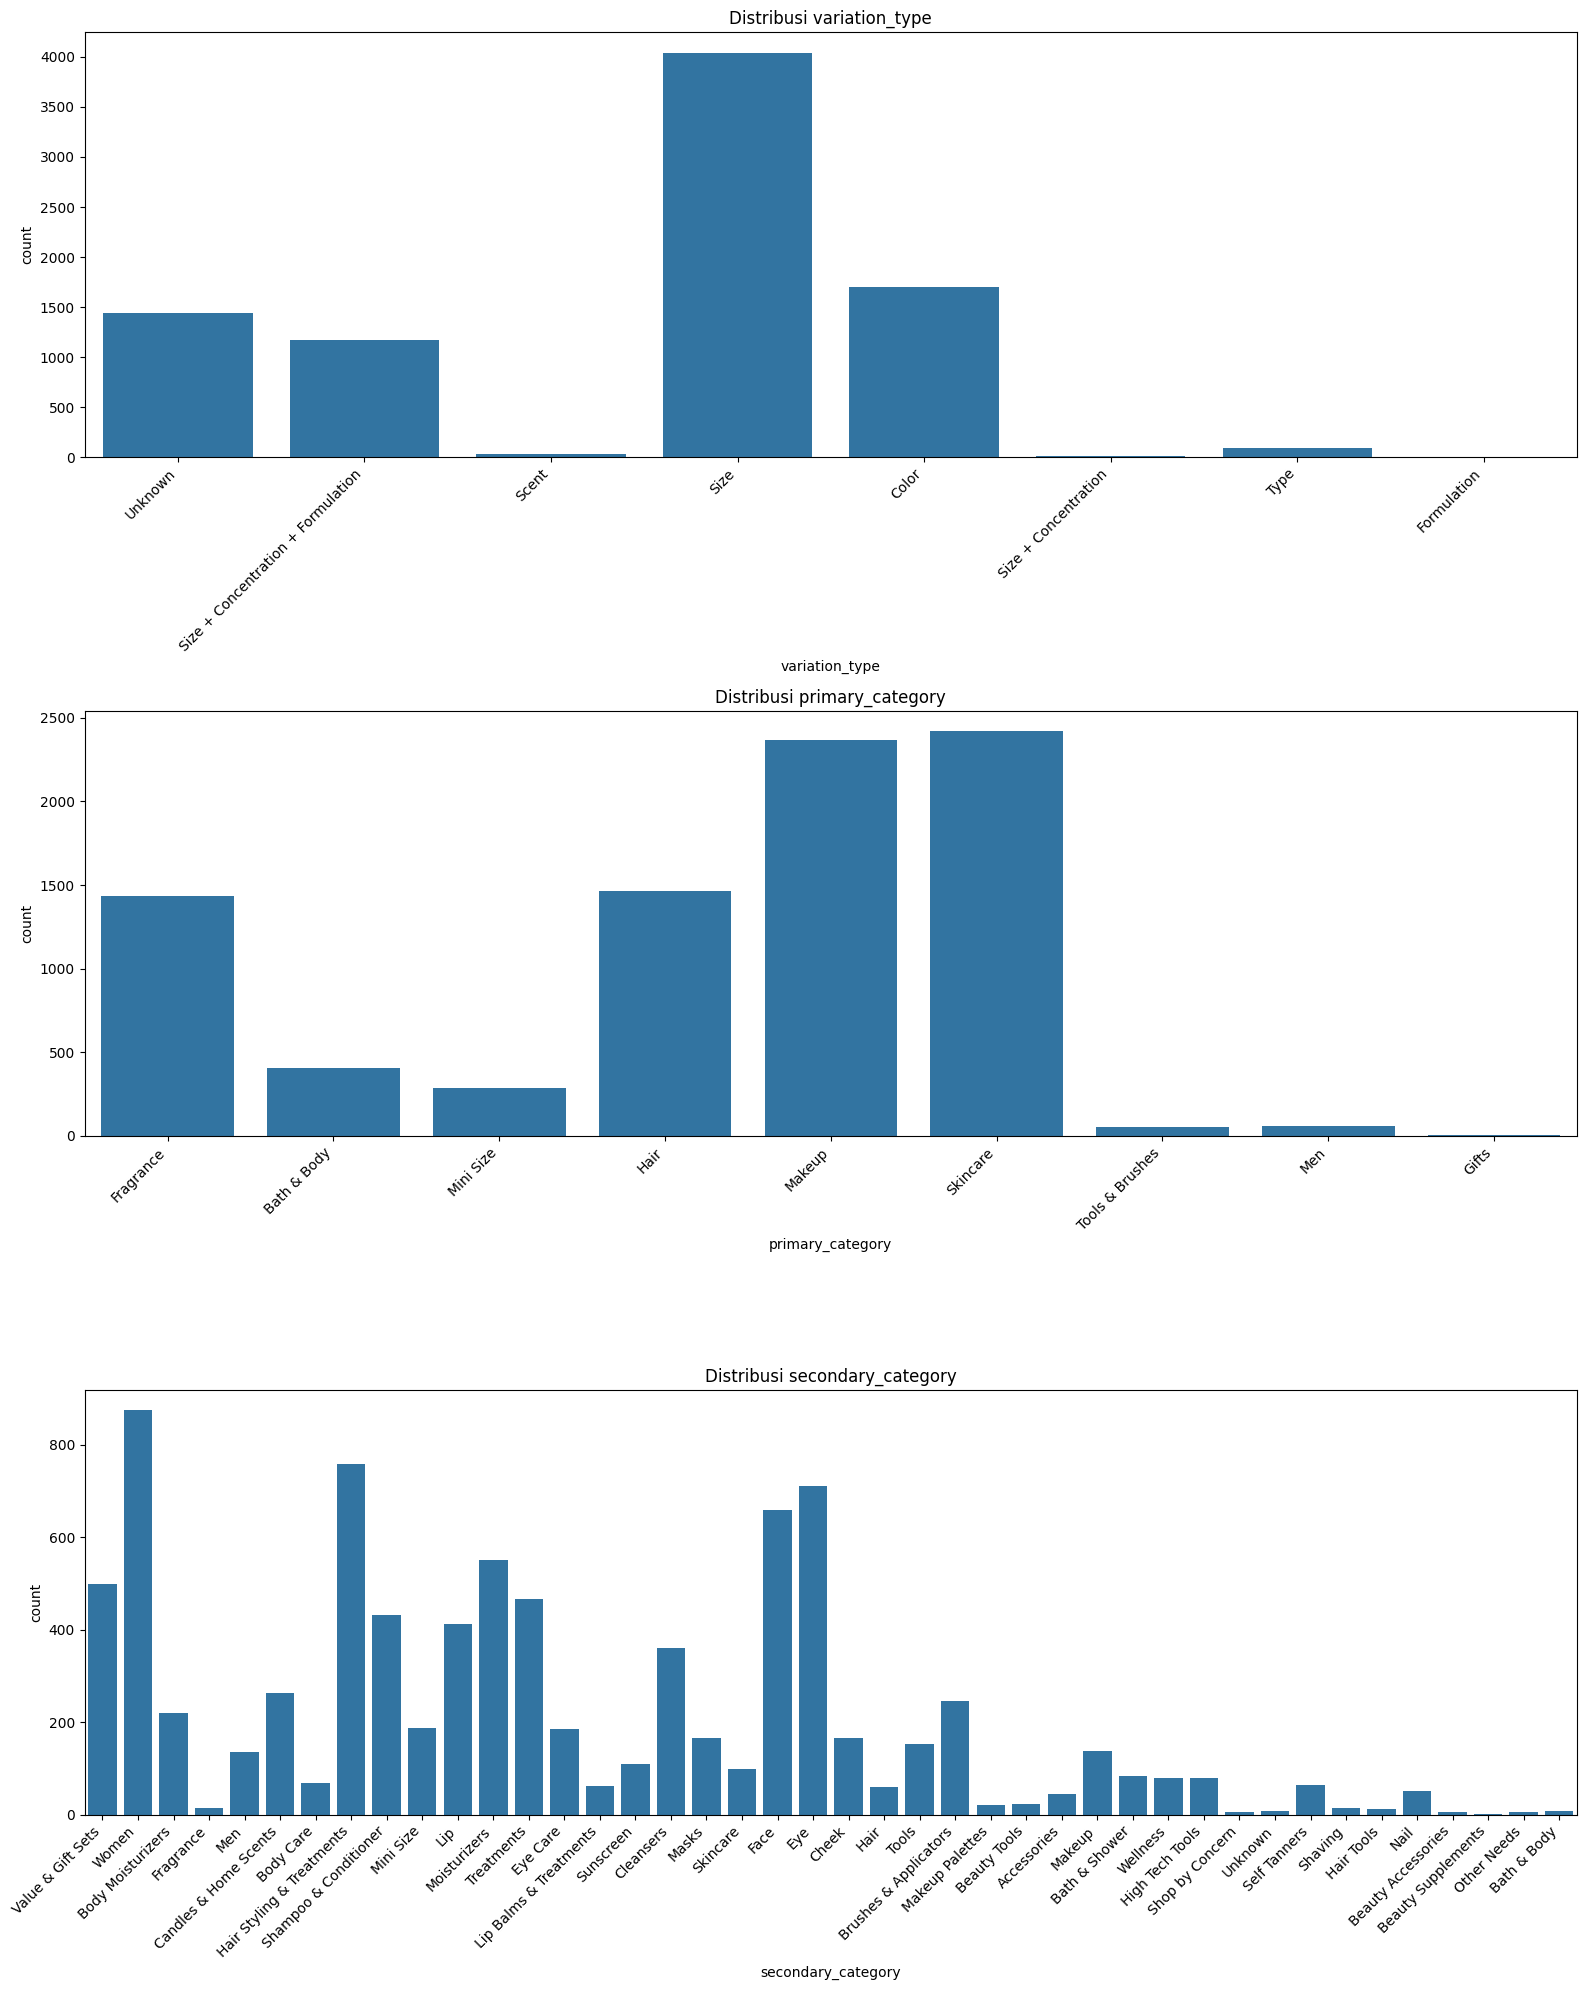

In [13]:
selected_categorical_features = ['variation_type', 'primary_category', 'secondary_category']
plt.figure(figsize=(16, 20))
for i, col in enumerate(selected_categorical_features, 1):
    plt.subplot(3, 1, i)
    sns.countplot(x=data[col])
    plt.title(f"Distribusi {col}")
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Pada distribusi fitur kategorikal hanya menampilkan kolom variation_type, primary_category, dan secondary_category, karena fitur lainnya memiliki banyak jenis yang membuatnya tidak memungkinkan untuk ditampilkan dalam bentuk subplot.

Pada variation_type, size menjadi data yang paling sering muncul.
Pada primary_category, makeup dan skincare menjadi data yang paling sering muncul.
Pada secondary_category, women menjadi data yang paling sering muncul.

### Correlation Matrix

Digunakan untuk melihat fitur apa saja yang memiliki korelasi.

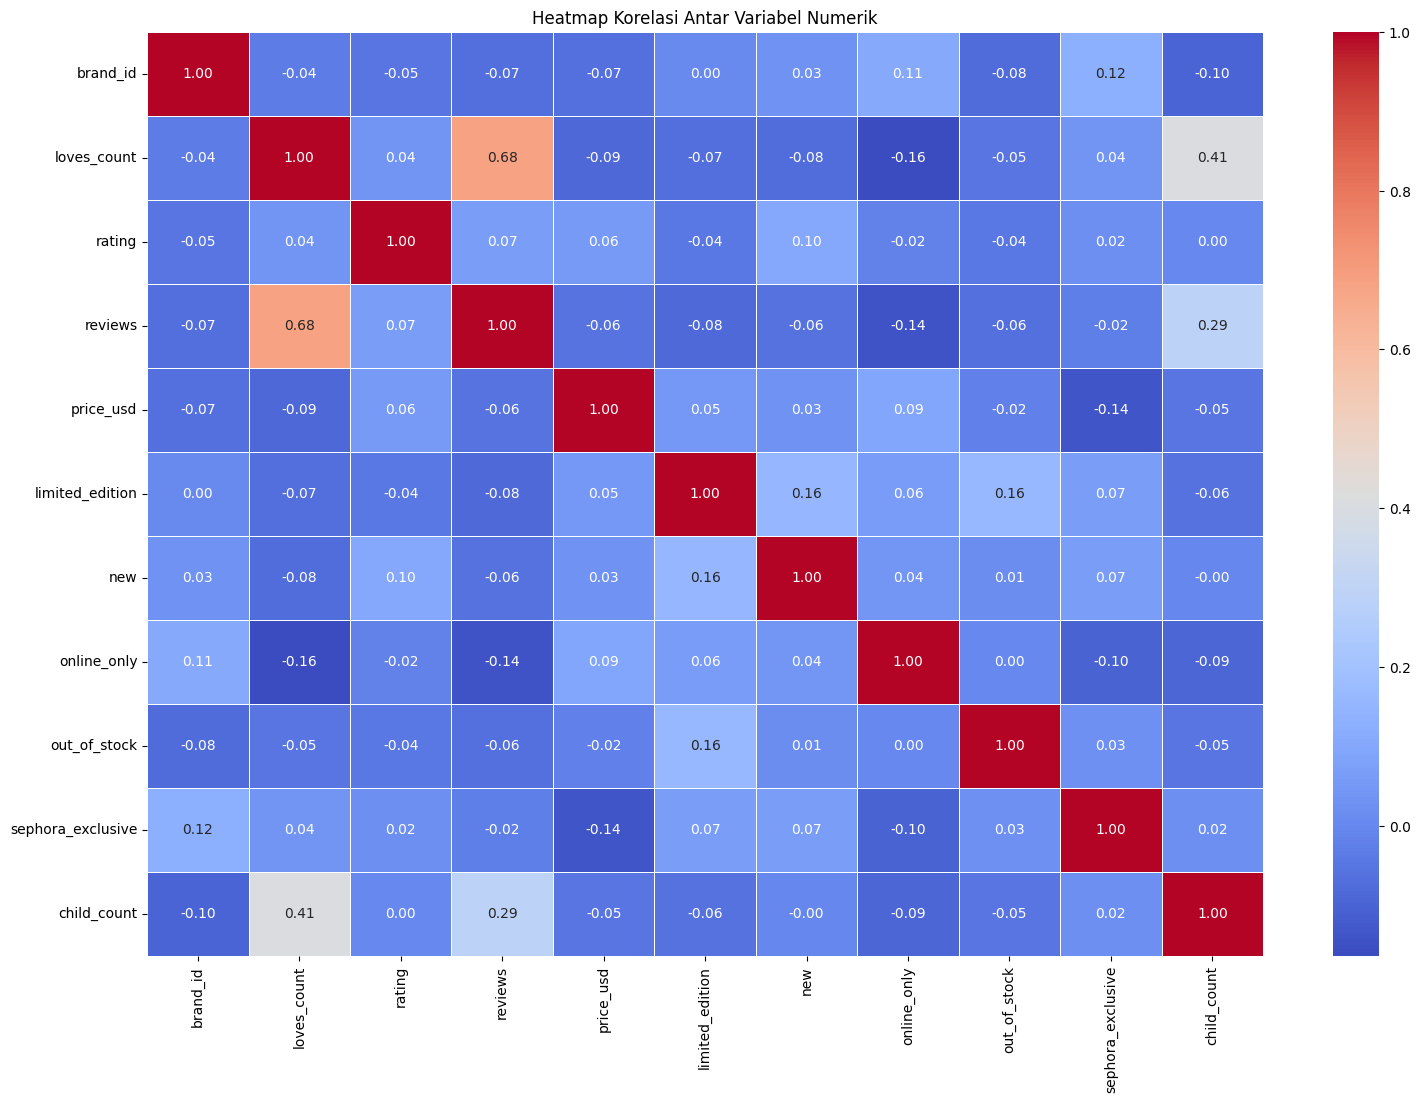

In [14]:
correlation = data[numeric_features].corr()
plt.figure(figsize=(18, 12))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik")
plt.show()

Terlihat pada metrik korelasi bahwa setiap fitur numerik tidak memiliki korelasi satu sama lain, kecuali fitur reviews dan loves_count. Kedua fitur tersebut berkorelasi positif, yang artinya jika fitur reviews meningkat maka fitur loves_count juga ikut meningkat.

## Data Preparation

Teknik yang akan dilakukan:
* Fitur selection : menghapus beberapa fitur yang tidak relevan
* Fitur Combine : menggabungkan beberapa fitur menjadi satu fitur
* Text Preprocessing : membersihkan data dari simbol, tanda baca, atau kata yang tidak terlalu bermakna
* TF-IDF Vectorizer

### Fitur Selection


Dilakukan untuk memilih fitur-fitur yang paling relevan dengan sistem rekomendasi, tujuannya untuk meningkatkan akurasi dan generalisasi model.

In [15]:
print(data.columns.tolist())

['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 'reviews', 'size', 'variation_type', 'variation_value', 'ingredients', 'price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count']


In [16]:
# Contoh drop kolom dengan korelasi sangat tinggi
data = data.drop(['brand_id', 'loves_count', 'rating', 'reviews', 'size', 'variation_type', 'variation_value', 'price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'child_count'], axis=1)

Kenapa banyak fitur yang dihapus?
Karena sistem rekomendasi ini sangat sederhana dan berbasis teks. Fitur yang dipilih pun akan cocok dengan pendekatan Content-Based Filtering dengan menggunakan TF-IDF dan Cosine Similarity.

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   product_id          8494 non-null   object
 1   product_name        8494 non-null   object
 2   brand_name          8494 non-null   object
 3   ingredients         8494 non-null   object
 4   highlights          8494 non-null   object
 5   primary_category    8494 non-null   object
 6   secondary_category  8494 non-null   object
 7   tertiary_category   8494 non-null   object
dtypes: object(8)
memory usage: 531.0+ KB


Alasan mengapa hanya fitur tersebut yang dipilih:
- **product_name** : akan digunakan sebagai identitas utama produk dan input dari pengguna untuk mencari rekomendasi
- **brand_name** : untuk memberikan informasi penting tentang produk dan pengguna dapat memilih brand sesuai dengan preferensi mereka
- **ingredients** : isi dari fitur ini penting untuk membandingkan produk
- **highlights** : berguna untuk mencocokan kebutuhan pengguna, karena berisi rangkuman poin penting dan manfaat produk
- **primary_category, secondary_category, tertiary_category** : digunakan untuk memahami jenis produk, dari umum ke spesifik
- **product_id** : fitur ini tidak masuk ke dalam pemodelan tapi akan digunakan sebagai referensi unik untuk identifikasi produk saat menampilkan hasil

### Fitur Combine

Dilakukan untuk membuat fitur baru dari kombinasi fitur lama untuk memperkuat sinyal dalam data. Tujuannya untuk menyediakan informasi tambahan yang tidak langsung terlihat dari fitur asli dan menangkap interaksi antar fitur, Ini akan memudahkan model dalam mengidentifikasi dua produk yang serupa, tapi beda brand.

In [18]:
data['category'] = (data['primary_category'] + ' ' +
                    data['secondary_category'] + ' ' +
                    data['tertiary_category'])

Menggabungkan fitur primary_category, secondary_category, dan tertiary_category menjadi satu fitur, yaitu category.

In [19]:
data['combined_text'] = (
    data['brand_name'] + ' ' +
    data['category'] + ' ' +
    data['highlights'] + ' ' +
    data['ingredients'])

Menggabungkan fitur brand_name, category, highlights, dan ingredients menjadi satu fitur, yaitu combined_text.

### Text Preprocessing

Tahap ini dilakukan agar data yang ada bersih dari karakter, simbol, atau kata yang tidak bermakna dan saat diaplikasikan ke model hasilnya dapat maksimal.

In [20]:
stop_words = set(stopwords.words('english'))

# Fungsi preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Terapkan ke kolom
data['cleaned_text'] = data['combined_text'].apply(clean_text)


```stop_words = set(stopwords.words('english')) ```
Kode tersebut mengambil daftar kata umu dalam bahasa inggris dan disimpan sebagai set untuk pencarian yang lebih tepat, yang digunakan untuk menghapus kata-kata yang tidak penting dari teks.

Fungsi ``` def clean_text(text) ``` : memiliki satu parameter, yaitu text dan berisi beberapa perintah, diantaranya adalah:
- ``` text.lower() ``` : digunakan untuk memngubah seluruh huruf dalam teks menjadi huruf kecil
- ``` re.sub(r'[^a-z\s]', '', text) ``` : digunakan untuk menghapus semua karakter selain huruf a-z dan spasi
- ``` text.split() ``` : digunakan untuk memecah teks menjadi daftar kata-kata berdasarkan spasi
- ``` [word for word in tokens if word not in stop_words] ``` : digunakan untuk menghapus stopwords dari daftar text
- ``` return ' '.join(tokens) ``` : digunakan untuk menggabungkan token yang tersisa menjadi satu kalimat string

Jadi, fungsi ```clean_text()``` adalah untuk menyamakan bentuk huruf, menghapus simbol atau angka, menghapus kata yang tidak bermakna, memecah kata, dan mengembalikannya menjadi teks bersih.




### TF-IDF Vektorizer

TF-IDF adalah metode konversi teks menjadi angka yang mencerminkan pentingnya suatu kata dalam sebuah dokumen relatif terhadap seluruh korpus

Kelebihan:
- Sederhana dan cepat digunakan
- Mengurangi bobot kata umum
- Fokus pada kata yang relevan

Kekurangan:
- Tidak memahami konteks
- Tidak menangkap urutan kata
- Tidak memperhitungkan sinonim

In [21]:
# Buat TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Ubah teks ke dalam bentuk matriks TF-IDF
tfidf_matrix = tfidf.fit_transform(data['cleaned_text'])

Penjelasan kode di atas:
- Variabel ``` tfidf ``` bertugas untuk mengubah teks menjadi angka dan menghapus stopwords. TF-IDF memberi bobot lebih besar pada kata yang sering muncul dalam satu dokumen tapi jarang muncul di semua dokumen, sehingga lebih informatif.
- Variabel ``` tfidf_matrix ``` bertugas untuk menerapkan TF-IDF pada kolom ``` cleaned_text ```, sehingga outputnya adalah angka-angka TF-IDF untuk digunakan dalam perhitungan kemiripan.

Jadi, inti dari kedua kode di atas adalah mengubah teks ke dalam bentuk angka berbobot yang bisa diproses oleh komputer untuk mencari kemiripan antar produk.

## Data Modelling

Hal yang dilakukan:
- Cosine Similarity
- Pengujian Model

### Cosine Similarity

Cosine similarity adalah ukuran kesamaan antara dua vektor berdasarkan sudut kosinus di antara mereka, bukan nilai absolut atau jarak euclidean. Fungsi utamanya untuk mengukur kemiripan dokumen teks, terutama yang direpresentasikan dalam bentuk TF-IDF.

Kelebihan:
- Tidak dipengaruhi oleh panjang dokumen
- Cepat dihitung dan efisien

Kekurangan:
- Tidak mempertimbangkan frekuensi kata yang tinggi
- Tidak memahami makna kata

In [22]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.67163015, 0.70389757, ..., 0.45734628, 0.25586016,
        0.00187167],
       [0.67163015, 1.        , 0.71431103, ..., 0.35239196, 0.18382928,
        0.00481223],
       [0.70389757, 0.71431103, 1.        , ..., 0.29655826, 0.1579479 ,
        0.        ],
       ...,
       [0.45734628, 0.35239196, 0.29655826, ..., 1.        , 0.44108693,
        0.13951017],
       [0.25586016, 0.18382928, 0.1579479 , ..., 0.44108693, 1.        ,
        0.16661605],
       [0.00187167, 0.00481223, 0.        , ..., 0.13951017, 0.16661605,
        1.        ]])

``` cosine_similarity ``` digunakan untuk menghitung kemiripan kosinus antara semua pasangan produk berdasarkan representasi TF-IDF. Jadi, kode ini menghitung seberapa mirip setiap produk dengan produk lain berdasarkan fitur teksnya. Tujuannya untuk menemukan produk yang paling mirip dengan produk tertentu.

In [23]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['product_name'], columns=data['product_name'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (8494, 8494)


product_name,DeliKate Recovery Serum,Bestsellers Recruitment Set,GOOPGENES All-In-One Nourishing Eye Cream,Mini Good Girl Eau de Parfum,Candleglow Sheer Perfecting Powder
product_name,,,,,
Mini All in One Leave-In Conditioner,0.068291,0.112922,0.104586,0.043469,0.075862
Curl Enhancer Conditioning Cream,0.042340,0.079412,0.057820,0.071914,0.030120
Skin Corrector Stick,0.032437,0.099095,0.061213,0.021800,0.173976
Restore Shampoo,0.079128,0.126617,0.061066,0.039263,0.075220
Nudies Matte Cream Blush,0.026786,0.056148,0.014193,0.023968,0.103785
Liquid Glass Instant Glossing Rinse,0.073931,0.159509,0.125312,0.064684,0.062032
Superpowder Double Face Makeup Foundation,0.032299,0.026354,0.039380,0.064821,0.302843
Sheer Liquid Eyeshadow,0.097760,0.121709,0.069884,0.045476,0.273260
One Two Lash Magnetic Lashes,0.005506,0.003588,0.026606,0.000000,0.017529


### Pengujian Model

In [24]:
pd.set_option('display.max_colwidth', 200)
def shorten_text(text, max_len=200):
    return text if len(text) <= max_len else text[:max_len-3] + "..."

def recommend(product_name, category=None, cosine_sim=cosine_sim):
    matches = data[data['product_name'].str.contains(product_name, case=False, na=False)]

    if matches.empty:
        return "Produk tidak ditemukan. Coba masukkan sebagian kata dari nama produk."

    print("Produk yang cocok dengan pencarianmu:")
    print(matches['product_name'].head(3).to_string(index=False))

    idx = matches.index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]

    product_indices = [i[0] for i in sim_scores]
    recommendations = data[['product_name', 'brand_name', 'category', 'ingredients', 'highlights']].iloc[product_indices]

    # Filter kategori jika diberikan
    if category:
        recommendations = recommendations[recommendations['category'].str.contains(category, case=False, na=False)]

    if recommendations.empty:
        return "Tidak ada produk rekomendasi yang cocok dengan filter kategori tersebut."

    recommendations['product_name'] = recommendations['product_name'].apply(shorten_text)
    recommendations['brand_name'] = recommendations['brand_name'].apply(shorten_text)
    recommendations['category'] = recommendations['category'].apply(shorten_text)
    recommendations['ingredients'] = recommendations['ingredients'].apply(shorten_text)
    recommendations['highlights'] = recommendations['highlights'].apply(shorten_text)
    print("\nRekomendasi produk untukmu:")
    return recommendations

Penjelasan kode di atas:
- Fungs ``` shorten_text ``` : memiliki dua parameter, yaitu:
  - text : berisi teks yang akan dipersingkat
  - max_len : panjang maksimum karakter teks yang diizinkan.
  
  Fungsi tersebut berfungsi untuk memotong teks panjang agar tidak melebihi max_len karakter.
- Fungsi ``` recommend ``` memiliki tiga parameter, yaitu:
  - product_name : nama dari produk yang akan dicari rekomendasinya.
  - category : opsional, diisi kategori produk yang diinginkan untuk filter hasil rekomendasi.
  - cosine_sim : matriks kemiripan produk.
  
  Fungsi tersebut memiliki beberapa perintah sebagai berikut:
  - variabel ``` matches ``` : berfungsi untuk mencari baris dalam data di mana kolom product_name mengandung string product_name.
  - ``` if matches.empty ``` : kondisi jika tidak ditemukan produk yang cocok, maka menghentikan fungsi dan mengembalikan pesan "Produk tidak ditemukan. Coba masukkan sebagian kata dari nama produk.".
  - ``` print("Produk yang cocok dengan pencarianmu:") ```
    
    ``` print(matches['product_name'].head(3).to_string(index=False)) ``` : untuk menampilkan maksimal 3 nama produk yang cocok.
  - ``` idx = matches.index[0] ``` : mengambil index baris pertama dari hasil pencarian matches, dimana index ini akan digunakan untuk mengambil skor cosine similarity.
  - ``` sim_scores = list(enumerate(cosine_sim[idx])) ``` : mengambil baris ke-idx dari cosine_sim yang berisi daftar kemiripan produk dengan semua produk.
  - ``` sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) ``` : mengurutkan pasangan (index, score) berdasarkan skor kemiripan dari yang paling tinggi ke paling rendah.
  - ``` sim_scores = sim_scores[1:11] ``` : mengambil 10 skor teratas, kecuali skore pertama.
  - ``` product_indices = [i[0] for i in sim_scores] ``` : mengambil hanya index produk dari sim_score.
  - ``` recommendations = data[['product_name', 'brand_name', 'category']].iloc[product_indices] ``` : mengambil kolom product_name, brand_name, dan category dari baris-baris yang indexnya paling mirip.
  - ``` if category: ``` : kondisi jika user memberikan filter category.
  - ``` if recommendations.empty: ``` : kondisi jika hasil filter kategori kosong.
  - ``` recommendations['product_name'] = recommendations['product_name'].apply(shorten_text) ```

    ```recommendations['brand_name'] = recommendations['brand_name'].apply(shorten_text) ```

    ``` recommendations['category'] = recommendations['category'].apply(shorten_text) ```
  : menerapkan fungsi shorten_text() ke masing-masing kolom agar teks panjang dipersingkat.
  - ``` return recommendations ``` : mengembalikan tabel hasil rekomendasi dalam bentuk dataframe.





Contoh penggunaan:

In [25]:
recommend('Cleanser', category='skincare')

Produk yang cocok dengan pencarianmu:
GENIUS Ultimate Anti-Aging Melting Cleanser
               Gentle Rejuvenating Cleanser
                         Balancing Cleanser

Rekomendasi produk untukmu:


,product_name,brand_name,category,ingredients,highlights
1096,Vinoclean Makeup Removing Cleansing Oil,Caudalie,Skincare Cleansers Face Wash & Cleansers,"['Helianthus Annuus (Sunflower) Seed Oil*, Polyglyceryl-4 Oleate*, Caprylic/Capric Triglyceride*, Ricinus Communis (Castor) Seed Oil*, Prunus Amygdalus Dulcis (Sweet Almond) Oil*, Vitis Vinifera (...","['Vegan', 'Clean + Planet Positive', 'Without Mineral Oil', 'Good for: Dryness']"
3555,Green Tea Hydrating Cleansing Oil,innisfree,Skincare Cleansers Face Wash & Cleansers,"['Triethylhexanoin, Isopropyl Palmitate, Caprylic/Capric Triglyceride, Sorbeth-30 Tetraoleate, Cetyl Ethylhexanoate, Olea Europaea (Olive) Fruit Oil, Cocos Nucifera (Coconut) Oil, Fragrance / Parf...","['Hydrating', 'Without Mineral Oil', 'Good for: Dryness', 'Without Parabens', 'Best for Dry, Combo, Normal Skin', 'Without Sulfates SLS & SLES']"
2238,Slaai Makeup-Melting Butter Cleanser,Drunk Elephant,Skincare Cleansers Face Wash & Cleansers,"['Ethylhexyl Palmitate, Caprylic/Capric Triglyceride, Carthamus Tinctorius (Safflower) Seed Oil, Lauryl Laurate, Polyglyceryl-3 Laurate, Polyhydroxystearic Acid, Helianthus Annuus (Sunflower) Seed...",Unknown
1281,Multi-Miracle Glow Cleansing Balm,Charlotte Tilbury,Skincare Cleansers Face Wash & Cleansers,"['Glycerin, Water, Caprylic/Capric Triglyceride, Cyclopentasiloxane, Sucrose Stearate, Phenyl Trimethicone, Phenoxyethanol, Microcrystalline Cellulose, Ethylhexylglycerin, Chlorphenesin, Cellulose...",Unknown
98,Advanced Anti-Aging Repairing Oil,Algenist,Skincare Moisturizers Face Oils,"['Chlorella Protothecoides Oil, Cetearyl Ethylhexanoate, Isopropyl Isostearate, Caprylic/Capric Triglyceride, Ceramide 3, Alaria Esculenta Extract, Retinyl Palmitate, Tocopherol, Rosmarinus Offici...",Unknown
558,The POREfessional Get Unblocked Makeup-Removing Cleansing Oil,Benefit Cosmetics,Skincare Cleansers Face Wash & Cleansers,"['Caprylic/Capric Triglyceride, Simmondsia Chinensis (Jojoba) Seed Oil, PEG-40 Sorbitan Peroleate, Persea Gratissima (Avocado) Oil, Vitis Vinifera (Grape) Seed Oil, 1,2-Hexanediol, Caprylyl Glycol...","['Good for: Dullness/Uneven Texture', 'Good for: Pores']"
4159,Ultra Facial Cream Refill Bundle,Kiehl's Since 1851,Skincare Value & Gift Sets Unknown,['Aqua / Water Glycerin Dimethicone Squalane Bis-Peg-18 Methyl Ether Dimethyl Silane Sucrose Stearate Stearyl Alcohol Peg-8 Stearate Myristyl Myristate Prunus Armeniaca Kernel Oil / Apricot Kernel...,"['Clean at Sephora', 'Good for: Dryness', 'Without Parabens']"


Sistem memberikan 10 rekomendasi produk yang mirip dengan Vitamin C Serum.

In [26]:
recommend('Mascara', category='makeup')

Produk yang cocok dengan pencarianmu:
Lash-Amplifying Volumizing & Lengthening Mascara
          Lash Brag Jet-Black Volumizing Mascara
     Mini Lash Brag Jet-Black Volumizing Mascara

Rekomendasi produk untukmu:


,product_name,brand_name,category,ingredients,highlights
4951,Brow 1980 Volumizing Eyebrow Pomade Gel,MERIT,Makeup Eye Eyebrow,"['Aqua (Water, Eau), Mica, Cera Carnauba (Copernicia Cerifera (Carnauba) Wax, Cire de Carnauba), Polyisobutene, Propanediol, Glyceryl Stearate, Polyacrylate-21, Kaolin, Palmitic Acid, Oleic Acid, ...","['Cruelty-Free', 'Volumizing', 'Vegan', 'Long-wearing', 'Fragrance Free', 'Clean at Sephora']"
3349,LEGIT LASHES Double-Ended Volumizing and Lengthening Mascara,HUDA BEAUTY,Makeup Eye Mascara,"['Volume:', 'Water/Aqua/Eau, Beeswax/Cera Alba/Cire d’abeille, Stearic Acid, Helianthus Annuus (Sunflower) Seed Wax, Glyceryl Behenate, Acacia Senegal Gum, Polyglyceryl-6 Distearate, Vp/Eicosene C...","['Matte Finish', 'Volumizing', 'Curling', 'Lengthening']"
4770,The Professionall 24HR Double-Ended Lifting & Volumizing Mascara,MAKE UP FOR EVER,Makeup Eye Mascara,"['Step 1:', 'Aqua (Water), Candelilla Cera (Euphorbia Cerifera (Candelilla) Wax), Synthetic Beeswax, Vp/Eicosene Copolymer, Paraffin, Polyacrylate-21, Copernicia Cerifera (Carnauba) Wax, Stearyl A...","['Volumizing', 'Long-wearing', 'Lengthening', 'Curling']"
3369,Mini LEGIT LASHES Double-Ended Volumizing and Lengthening Mascara,HUDA BEAUTY,Mini Size Makeup Unknown,"['Volume:', 'Water/Aqua/Eau, Beeswax/Cera Alba/Cire d’abeille, Stearic Acid, Helianthus Annuus (Sunflower) Seed Wax, Glyceryl Behenate, Acacia Senegal Gum, Polyglyceryl-6 Distearate, Vp/Eicosene C...","['Matte Finish', 'Volumizing', 'Curling', 'Lengthening']"
3037,L'Obscur Lengthening Mascara,Gucci,Makeup Eye Mascara,"['Aqua/Water/Eau, Synthetic Beeswax, Paraffin, Stearic Acid, Acacia Senegal Gum, Triethanolamine, Butylene Glycol, Copernicia Cerifera Cera/Copernicia Cerifera (Carnauba) Wax/Cire de Carnauba, Pol...","['allure 2020 Best of Beauty Award Winner', 'Long-wearing', 'Lengthening', 'Without Parabens']"
6256,Perfect Strokes Universal Volumizing Mascara,Rare Beauty by Selena Gomez,Makeup Eye Mascara,"['Water/Aqua/Eau, Copernicia Cerifera (Carnauba) Wax/Cera Carnauba/Cire de carnauba, Glyceryl Stearate, Hydrogenated Olive Oil Stearyl Esters, Synthetic Wax, Stearic Acid, Helianthus Annuus (Sunfl...","['Volumizing', 'Curling', 'Lengthening', 'Long-wearing', 'Without Parabens', 'Vegan']"
3117,Noir G Volumizing & Curling Mascara,GUERLAIN,Makeup Eye Mascara,"['Aqua (Water), Olea Europaea (Olive) Oil Unsaponifiables, Cera Alba (Beeswax), Polyacrylate-21, Bis-Diglyceryl Polyacyladipate-2, Candelilla Cera (Euphorbia Cerifera (Candelilla) Wax), Cera Carna...","['Volumizing', 'Waterproof', 'Curling']"
3110,Mad Eyes Mascara Long-Wearing & Volumizing,GUERLAIN,Makeup Eye Mascara,"['Aqua (Water), Cera Alba (Beeswax), Propanediol, Glyceryl Stearate, Polyacrylate-21, Bis-Diglyceryl Polyacyladipate-2, Alcohol, Candelilla Cera (Euphorbia Cerifera (Candelilla) Wax), Cera Carnaub...",Unknown
1258,Legendary Lashes Volume 2 Mascara,Charlotte Tilbury,Makeup Eye Mascara,"['Water, Synthetic Beeswax, Paraffin, Stearic Acid, Acacia Senegal Gum, Triethanolamine, Butylene Glycol, Copernicia Cerifera (Carnauba) Wax/Cire De Carnauba, Polybutene, Vp/Eicosene Copolymer, Gl...",Unknown
7843,Better Than Sex Volumizing & Lengthening Mascara,Too Faced,Makeup Eye Mascara,"['Chocolate: Water\\Aqua\\Eau, Paraffin, Glyceryl Stearate, Synthetic Beeswax, Acacia Senegal Gum, Butylene Glycol, Stearic Acid, Palmitic Acid, Polybutene, Oryza Sativa (Rice) Bran Wax, Ozokerite...","['Volumizing', 'Lengthening', 'Cruelty-Free']"


Dapat dilihat pada pengujian di atas, 10 rekomendasi produk teratas yang ditampilkan memiliki kemiripan dengan parameter yang digunakan.

## Evaluasi

### Precision

Untuk Content-Based Filtering digunakan metrik evaluasi precision untuk melihat seberapa baik sistem rekomendasi menggunakan Cosine Similarity. Precision adalah metrik evaluasi yang akan mengukur seberapa banyak dari hasil yang ditampilkan oleh sistem benar-benar relevan. Precision memberikan gambaran seberapa banyak dari prediksi yang dikategorikan positif benar-benar merupakan kasus positif yang sebenarnya.

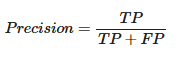


Dimana:
- TP (True Positive), jumlah kejadian positif yang diprediksi dengan benar.
- FP (False Positive), jumlah kejadian positif yang diprediksi dengan salah.

Karena dalam pengujian dilakukan dua kali, maka untuk menghitung precision akan menggunakan average precision. Average precision dapat memberikan informasi terkait rata-rata performa sistem rekomendasi.

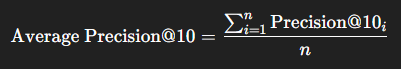

Dimana:
- n : jumlah pengujian
- Precision@10𝑖: nilai precision dari setiap pengujian.


Pada pengujian pertama:
recommend('Cleanser', category='skincare') menghasilkan 7 rekomendasi, dimana ada 2 rekomendasi yang tidak relevan. Artinya, pengujian pertama memiliki precision sebesar **0.7**.

Pada pengujian kedua:
recommend('Waterproof', category='makeup') menghasilkan 10 rekomendasi, dimana ada 1 rekomendasi yang tidak relevan. Artinya, pengujian pertama memiliki precision sebesar **0.9**.

Rata-rata precision:
Pada pengujian pertama didapat hasil 0.7 dan pada pengujian kedua didapat hasil 0.9, maka rata-rata precision adalah sebesar **0.8**.

## Dampak Model terhadap Business Understanding
### Apakah Model Menjawab Problem Statements?
* **Ya**, model merekomendasikan produk yang relevan dengan bantuan dari TF-IDf dan Cosine Similarity, dimana pengguna hanya perlu memasukan yang ingin direkomendasikan dan memasukan kategori yang relevan dengan preferensi pengguna.

### Apakah Model Berhasil Mencapai Goals?
* **Ya**, model berhasil menciptakan sistem rekomendasi dan memberikan Top 10 Recommendation berdasarkan dengan produk dan kategori produk.

### Apakah Solusi yang Direncanakan Berdampak?
* **Ya**, solusi berdampak pada model dan hasil dari model. dengan penggabungan fitur, sistem dapat mengeneralisir
